In [1]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

from idrf import IDRF #Deconvolution routine

In [2]:
from obspy.clients.fdsn.client import Client

client = Client('IRIS')

network = 'IU'
station = 'RSSD'

inv = client.get_stations(network=network, station=station,level='response')

sta = inv[0][0]
sta

Station RSSD (Black Hills, South Dakota, USA)
	Station Code: RSSD
	Channel Count: 72/72 (Selected/Total)
	1999-09-24T00:00:00.000000Z - 2009-09-08T20:00:00.000000Z
	Access: open 
	Latitude: 44.12, Longitude: -104.04, Elevation: 2090.0 m
	Available Channels:
		RSSD..BC0, RSSD..BC1, RSSD.00.BHZ (3x), RSSD.00.BH1 (4x), 
		RSSD.00.BH2 (4x), RSSD.00.LHZ (3x), RSSD.00.LH1 (4x), 
		RSSD.00.LH2 (4x), RSSD.00.UHZ (2x), RSSD.00.UH1 (3x), 
		RSSD.00.UH2 (3x), RSSD.00.VE1, RSSD.00.VHZ (3x), RSSD.00.VH1 (4x), 
		RSSD.00.VH2 (4x), RSSD.00.VK1, RSSD.10.BHZ, RSSD.10.BHN, RSSD.10.BHE
		RSSD.10.HHZ, RSSD.10.HHN, RSSD.10.HHE, RSSD.10.LHZ, RSSD.10.LHN, 
		RSSD.10.LHE, RSSD.20.HLZ, RSSD.20.HLN, RSSD.20.HLE, RSSD.20.HNZ (2x)
		RSSD.20.HNN (2x), RSSD.20.HNE (2x), RSSD.20.LLZ, RSSD.20.LLN, 
		RSSD.20.LLE, RSSD.20.LNZ (2x), RSSD.20.LNN (2x), RSSD.20.LNE (2x)

In [3]:
import wget

!rm *.ndk

years = range(6,18)
months  = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
for year in years:
    for month in months:
        url='http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/20%02d/%s%02d.ndk' % (year, month, year)
        print(url)
        wget.download( url )

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jan06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/feb06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/mar06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/apr06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/may06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jun06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jul06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/aug06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/sep06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/oct06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/nov06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/dec06.ndk
http

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/apr14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/may14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jun14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jul14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/aug14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/sep14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/oct14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/nov14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/dec14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/jan15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/feb15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/mar15.ndk
http

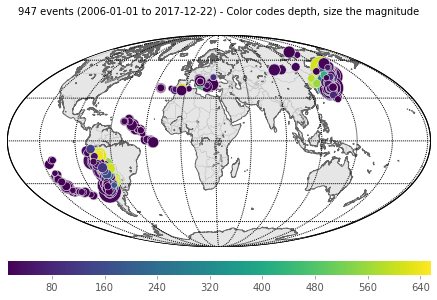

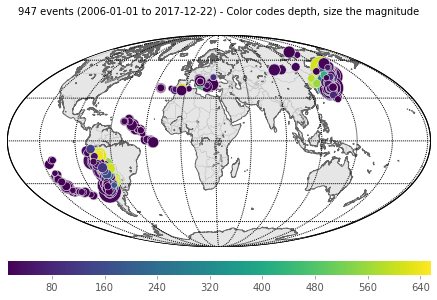

In [4]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = obspy.core.event.Catalog()

for year in years:
    for month in months:
        tmp = obspy.read_events('%s%02d.ndk' % (month, year))
        cat = cat + tmp.filter('magnitude >= 5.5')
    
    
cat2 = obspy.core.event.Catalog()

for evt in cat:
    elat=evt.origins[0].latitude
    elon=evt.origins[0].longitude
    slat=sta.latitude
    slon=sta.longitude
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg=delm/1000/111.11
    if deldeg > 55 and deldeg < 85:
        cat2.append(evt)
        
cat2.plot()
    

In [5]:
from scipy.signal import tukey
from numpy import arange, linspace, zeros
from numpy.random import randn
from numpy import argmax, nan
import warnings
warnings.filterwarnings('ignore')

model = TauPyModel(model="iasp91")

#tries = linspace(0.5, 0.90, 5)
pctage=0.50

#tshifts = [-6, -3, 0, 3, 6]
tshifts = [0]

rbin    = zeros(len(tshifts)*len(cat2)*700).reshape(len(tshifts),len(cat2),700) * nan
rbin_s  = rbin.copy()
mbin1   = zeros(len(tshifts)*len(cat2)).reshape(len(tshifts),len(cat2)) * nan
mbin1_s = mbin1.copy()
mbin2   = mbin1.copy()
mbin2_s = mbin1.copy()

for ievt in range(len(cat2)):
    if ievt == 300:
        break
    
    print('Working on %5d of %5d' % (ievt+1,len(cat2)))

    strike=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
    dip=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
    rake=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake

    quake_depth_in_km=cat2[ievt].preferred_origin().depth/1000.0
    
    etime = cat2[ievt].preferred_origin().time

    slat=sta.latitude
    slon=sta.longitude
    elat=cat2[ievt].preferred_origin().latitude
    elon=cat2[ievt].preferred_origin().longitude

    client_syn = Client()
    
    t1=etime
    t2=etime+3600./2.

    for wvfrm_type in ['data','synthetic']:
        print(wvfrm_type)
        if wvfrm_type == 'synthetic'and data_download_success == False:
            break
    
        if wvfrm_type == 'synthetic':
            tmpstr = '%8.1f %8.1f %6.1f %8.1f %8.1f %8.2f %8.2f %8.2f ' % (elat, elon, quake_depth_in_km, slat, slon, strike, dip, rake)
            print(tmpstr)
            stis = client_syn.get_waveforms(model="iasp91_2s",
                                              sourcelatitude=elat,
                                              sourcelongitude=elon,
                                              sourcedepthinmeters=1000.*quake_depth_in_km,
                                              receiverlatitude=slat, receiverlongitude=slon,
                                              sourcedoublecouple=[strike,dip,rake],
                                              origintime=etime,
                                              units='velocity', starttime=t1, endtime=t2)
        else:
            #
            try:
                stis=client.get_waveforms(network,station,'*','LH?',t1,t2,attach_response=True)
                pre_filt = (0.005, 0.01, 5.0, 10.0)
                stis.remove_response(output='VEL', pre_filt=pre_filt)
            except:
                print('  get_waveforms failed.')
                break


            #

        print(stis)

        #print('...strike, dip, rake, elat, elon, quake_depth_in_km = %3d %3d %3d %5d %5d %5d %5d' % (strike, dip, rake, elat, elon, slat, quake_depth_in_km))


        delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
        deldeg=delm/1000/111.11

        arrivals = model.get_travel_times(source_depth_in_km=quake_depth_in_km, distance_in_degree=deldeg,phase_list=['S'])

        try:
            stis.rotate('->ZNE',inventory=inv)
            #stis.rotate('NE->RT', back_azimuth = baz)
            stis.rotate('ZNE->LQT', inclination=arrivals[0].incident_angle, back_azimuth = baz)
            stis.detrend()
            data_download_success = True
        except ValueError as e:
            print('Error: %s' % e)
            data_download_success = False
            break

        stis.filter('bandpass', freqmin = 1./100., freqmax = 1./8., zerophase=True)
        #stis.filter('highpass', freq=1./20., zerophase=True)
        stis.resample(5)
        stis.differentiate()

        t1=etime+arrivals[0].time - 50
        t2=etime+arrivals[0].time + 50

        for ii, tshift in enumerate(tshifts):

            
            stis2=stis.copy().trim(t1+tshift,t2+tshift)
            
            try:
                dt = stis2[0].stats.delta
            except IndexError as e:
                print(e)
                break
                
            try:
                assert 'L' in stis2[0].stats.channel
                assert 'Q' in stis2[1].stats.channel
                #assert 'T' in stis2[2].stats.channel
            except AssertionError as e:
                print(e)
                break
            except IndexError as e:
                print(e)
                break
            
            

            P = stis2[1].copy().data
            D = stis2[0].copy().data

            #Indeces to mask out
            i1 = int(len(P) * (pctage)/2)
            i2 = int(len(P) - i1)
            
            N1=P.copy()[:i1]
            N2=D.copy()[:i1]

            P[:i1]=0.0
            P[i2:]=0.0
            P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))
            
            if wvfrm_type == 'synthetic':
                pass
            else:
                smax  = max(abs(P))
                nmax1 = max(abs(N1))
                nmax2 = max(abs(N2))
    
            #print(i1,i2,imax)
            
            TB = 1.5
            NT = 2

            Poverlap = 0.99
            win_len  = 100

            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
            
            times, RF     = IDRF(P,D,dt)
            _,     RFnorm = IDRF(P,D,dt)
            
            #_, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

            if wvfrm_type == 'synthetic':
                rbin_s[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1_s[ii,ievt] = smax/nmax1
                mbin2_s[ii,ievt] = smax/nmax2
            else:
                rbin[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1[ii,ievt] = smax/nmax1
                mbin2[ii,ievt] = smax/nmax2
        

Working on     1 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
synthetic
    31.5    140.1   12.0     44.1   -104.0    72.00    37.00    96.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-01-01T07:34:19.200000Z - 2006-01-

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-04-09T20:50:51.523182Z - 2006-04-09T21:20:50.523182Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-04-09T20:50:51.523178Z - 2006-04-09T21:20:50.523178Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-04-09T20:50:51.523178Z - 2006-04-09T21:20:50.523178Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-04-09T20:50:51.523187Z - 2006-04-09T21:20:50.523187Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-04-09T20:50:51.523187Z - 2006-04-09T21:20:50.523187Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-04-09T20:50:51.523182Z - 2006-04-09T21:20:50.523182Z | 1.0 Hz, 1800 samples
synthetic
   -20.5    -70.7   39.0     44.1   -104.0    49.00    30.00   106.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-04-09T21:10:31.500000Z - 2006-04-09T21:12:11.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-04-09T21:10:31.500000Z - 2006-04-09T21:12:11.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-04-09T21:10:31.500000Z - 2006-04-09T21:12:11.400000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-04-20T17:50:43.623137Z - 2006-04-20T18:20:42.623137Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-04-20T17:50:43.623138Z - 2006-04-20T18:20:42.623138Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-04-20T17:50:43.623135Z - 2006-04-20T18:20:42.623135Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-04-20T17:50:43.623139Z - 2006-04-20T18:20:42.623139Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-04-20T17:50:43.623139Z - 2006-04-20T18:20:42.623139Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-04-20T17:50:43.623139Z - 2006-04-20T18:20:42.623139Z | 1.0 Hz, 1800 samples
synthetic
    34.9    139.2   12.0     44.1   -104.0   170.00    84.00     3.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-04-20T18:12:33.700000Z - 2006-04-20T18:14:13.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-04-20T18:12:33.700000Z - 2006-04-20T18:14:13.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-04-20T18:12:33.700000Z - 2006-04-20T18:14:13.600000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-05-22T13:08:05.549102Z - 2006-05-22T13:38:04.549102Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-05-22T13:08:05.549102Z - 2006-05-22T13:38:04.549102Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-05-22T13:08:05.549117Z - 2006-05-22T13:38:04.549117Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-05-22T13:08:05.549038Z - 2006-05-22T13:38:04.549038Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-05-22T13:08:05.549038Z - 2006-05-22T13:38:04.549038Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-05-22T13:08:05.549062Z - 2006-05-22T13:38:04.549062Z | 1.0 Hz, 1800 samples
synthetic
    54.2    158.9  198.0     44.1   -104.0   262.00    19.00   -51.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-05-22T13:24:50.300000Z - 2006-05-22T13:26:30.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-05-22T13:24:50.300000Z - 2006-05-22T13:26:30.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-05-22T13:24:50.300000Z - 2006-05-22T13:26:30.200000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-08-17T15:20:38.699089Z - 2006-08-17T15:50:37.699089Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-08-17T15:20:38.699020Z - 2006-08-17T15:50:37.699020Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-08-17T15:20:38.699086Z - 2006-08-17T15:50:37.699086Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-08-17T15:20:38.699013Z - 2006-08-17T15:50:37.699013Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-08-17T15:20:38.699018Z - 2006-08-17T15:50:37.699018Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-08-17T15:20:38.699038Z - 2006-08-17T15:50:37.699038Z | 1.0 Hz, 1800 samples
synthetic
    46.5    141.8   18.1     44.1   -104.0   347.00    35.00    95.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-08-17T15:40:39.600000Z - 2006-08-17T15:42:19.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-08-17T15:40:39.600000Z - 2006-08-17T15:42:19.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-08-17T15:40:39.600000Z - 2006-08-17T15:42:19.500000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-09-24T21:08:43.535429Z - 2006-09-24T21:38:42.535429Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-09-24T21:08:43.535438Z - 2006-09-24T21:38:42.535438Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-09-24T21:08:43.535429Z - 2006-09-24T21:38:42.535429Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-09-24T21:08:43.535433Z - 2006-09-24T21:38:42.535433Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-09-24T21:08:43.535430Z - 2006-09-24T21:38:42.535430Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-09-24T21:08:43.535434Z - 2006-09-24T21:38:42.535434Z | 1.0 Hz, 1800 samples
synthetic
   -31.9    -67.2  151.6     44.1   -104.0   122.00    34.00  -131.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-09-24T21:30:07.600000Z - 2006-09-24T21:31:47.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-09-24T21:30:07.600000Z - 2006-09-24T21:31:47.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-09-24T21:30:07.600000Z - 2006-09-24T21:31:47.500000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-10-10T23:58:09.535400Z - 2006-10-11T00:28:08.535400Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-10-10T23:58:09.535400Z - 2006-10-11T00:28:08.535400Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-10-10T23:58:09.535400Z - 2006-10-11T00:28:08.535400Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-10-10T23:58:09.535400Z - 2006-10-11T00:28:08.535400Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-10-10T23:58:09.535400Z - 2006-10-11T00:28:08.535400Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-10-10T23:58:09.535400Z - 2006-10-11T00:28:08.535400Z | 1.0 Hz, 1800 samples
synthetic
    37.2    143.0   19.1     44.1   -104.0   208.00    18.00    93.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-10-11T00:19:18.100000Z - 2006-10-11T00:20:58.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-10-11T00:19:18.100000Z - 2006-10-11T00:20:58.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-10-11T00:19:18.100000Z - 2006-10-11T00:20:58.000000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-10-26T22:54:37.460646Z - 2006-10-26T23:24:36.460646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-10-26T22:54:37.460646Z - 2006-10-26T23:24:36.460646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-10-26T22:54:37.460646Z - 2006-10-26T23:24:36.460646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-10-26T22:54:37.460646Z - 2006-10-26T23:24:36.460646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-10-26T22:54:37.460646Z - 2006-10-26T23:24:36.460646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-10-26T22:54:37.460646Z - 2006-10-26T23:24:36.460646Z | 1.0 Hz, 1800 samples
synthetic
   -13.4    -76.9   24.5     44.1   -104.0   329.00    13.00    65.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-10-26T23:12:33.900000Z - 2006-10-26T23:14:13.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-10-26T23:12:33.900000Z - 2006-10-26T23:14:13.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-10-26T23:12:33.900000Z - 2006-10-26T23:14:13.800000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-11-15T11:15:08.060322Z - 2006-11-15T11:45:07.060322Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-11-15T11:15:08.060356Z - 2006-11-15T11:45:07.060356Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-11-15T11:15:08.060363Z - 2006-11-15T11:45:07.060363Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-11-15T11:15:08.060365Z - 2006-11-15T11:45:07.060365Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-15T11:15:08.060363Z - 2006-11-15T11:45:07.060363Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-15T11:15:08.060361Z - 2006-11-15T11:45:07.060361Z | 1.0 Hz, 1800 samples
synthetic
    46.7    154.3   13.5     44.1   -104.0   215.00    15.00    92.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-11-15T11:33:54.500000Z - 2006-11-15T11:35:34.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-11-15T11:33:54.500000Z - 2006-11-15T11:35:34.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-11-15T11:33:54.500000Z - 2006-11-15T11:35:34.400000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2006-11-30T23:38:15.059700Z - 2006-12-01T00:08:14.059700Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2006-11-30T23:38:15.059753Z - 2006-12-01T00:08:14.059753Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2006-11-30T23:38:15.059755Z - 2006-12-01T00:08:14.059755Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2006-11-30T23:38:15.059756Z - 2006-12-01T00:08:14.059756Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-30T23:38:15.059700Z - 2006-12-01T00:08:14.059700Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-30T23:38:15.059753Z - 2006-12-01T00:08:14.059753Z | 1.0 Hz, 1800 samples
synthetic
   -29.6   -112.3   14.4     44.1   -104.0    39.00    71.00    -7.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-11-30T23:58:30.500000Z - 2006-12-01T00:00:10.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-11-30T23:58:30.500000Z - 2006-12-01T00:00:10.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-11-30T23:58:30.500000Z - 2006-12-01T00:00:10.400000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-01-13T17:37:12.135646Z - 2007-01-13T18:07:11.135646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-01-13T17:37:12.135646Z - 2007-01-13T18:07:11.135646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-01-13T17:37:12.135646Z - 2007-01-13T18:07:11.135646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-01-13T17:37:12.135646Z - 2007-01-13T18:07:11.135646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-01-13T17:37:12.135646Z - 2007-01-13T18:07:11.135646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-01-13T17:37:12.135646Z - 2007-01-13T18:07:11.135646Z | 1.0 Hz, 1800 samples
synthetic
    47.0    156.4   28.0     44.1   -104.0   301.00    51.00   -36.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 

6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-03-10T21:13:04.185646Z - 2007-03-10T21:43:03.185646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-03-10T21:13:04.185646Z - 2007-03-10T21:43:03.185646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-03-10T21:13:04.185646Z - 2007-03-10T21:43:03.185646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-03-10T21:13:04.185646Z - 2007-03-10T21:43:03.185646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-03-10T21:13:04.185646Z - 2007-03-10T21:43:03.185646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-03-10T21:13:04.185646Z - 2007-03-10T21:43:03.185646Z | 1.0 Hz, 1800 samples
synthetic
    55.1    162.6   44.8     44.1   -104.0   200.00    32.00    73.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-03-10T21:29:47.600000Z - 2007-03-10T21:31:27.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-03-10T21:29:47.600000Z - 2007-03-10T21:31:27.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-03-10T21:29:47.600000Z - 2007-03-10T21:31:27.500000Z | 10.0 Hz, 

synthetic
    48.2    155.2   33.5     44.1   -104.0   208.00    30.00    81.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-04-09T10:36:31.200000Z - 2007-04-09T10:38:11.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-04-09T10:36:31.200000Z - 2007-04-09T10:38:11.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-04-09T10:36:31.200000Z - 2007-04-09T10:38:11.100000Z | 10.0 Hz, 1000 samples
Working on   105 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-04-13T18:24:26.110651Z - 2007-04-13T18:54:25.110651Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-04-13T18:24:26.110653Z - 2007-04-13T18:54:25.110653Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-04-13T18:24:26.110653Z - 2007-04-13T18:54:25.110653Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-04-13T18:24:26.110651Z - 2007-04-13T18:54:25.110651Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-04-13T18:24:26.110654Z - 2007-04-13T18:54:25.110654Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-04-13T18:24:26.110654Z - 2007-04

synthetic
   -15.8    -75.2   15.0     44.1   -104.0   318.00    16.00    64.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
Working on   113 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-06-28T19:25:23.398034Z - 2007-06-28T19:55:22.398034Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-06-28T19:25:23.398043Z - 2007-06-28T19:55:22.398043Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-06-28T19:25:23.398065Z - 2007-06-28T19:55:22.398065Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-06-28T19:25:23.398043Z - 2007-06-28T19:55:22.398043Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-06-28T19:25:23.398041Z - 2007-06-28T19:55:22.398041Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-06-28T19:25:23.398051Z - 2007-06

synthetic
    36.8    135.0  374.9     44.1   -104.0   290.00    46.00   -10.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-07-16T14:38:26.000000Z - 2007-07-16T14:40:05.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-07-16T14:38:26.000000Z - 2007-07-16T14:40:05.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-07-16T14:38:26.000000Z - 2007-07-16T14:40:05.900000Z | 10.0 Hz, 1000 samples
Working on   121 of   947
data
  get_waveforms failed.
Working on   122 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-07-21T15:34:59.811037Z - 2007-07-21T16:04:58.811037Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-07-21T15:34:59.811037Z - 2007-07-21T16:04:58.811037Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-07-21T15:34:59.811037Z - 2007-07-21T16:04:58.811037Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-07-21T15:34:59.811037Z - 2007-07-21T16:04:58.811037Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-07-21T15:34:59.811037Z - 2007-07-21T16:04:58.811037Z | 1.0 Hz, 1800 samples

synthetic
   -14.2    -76.5   24.4     44.1   -104.0   335.00    23.00    78.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-17T06:36:19.000000Z - 2007-08-17T06:37:58.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-17T06:36:19.000000Z - 2007-08-17T06:37:58.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-17T06:36:19.000000Z - 2007-08-17T06:37:58.900000Z | 10.0 Hz, 1000 samples
Working on   130 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-08-17T13:18:13.148059Z - 2007-08-17T13:48:12.148059Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-08-17T13:18:13.148086Z - 2007-08-17T13:48:12.148086Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-08-17T13:18:13.148091Z - 2007-08-17T13:48:12.148091Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-08-17T13:18:13.148083Z - 2007-08-17T13:48:12.148083Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-08-17T13:18:13.148086Z - 2007-08-17T13:48:12.148086Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-08-17T13:18:13.148091Z - 2007-08

synthetic
   -21.1    -68.8  146.5     44.1   -104.0   168.00     6.00   -70.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-29T16:37:48.300000Z - 2007-08-29T16:39:28.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-29T16:37:48.300000Z - 2007-08-29T16:39:28.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-29T16:37:48.300000Z - 2007-08-29T16:39:28.200000Z | 10.0 Hz, 1000 samples
Working on   138 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-09-03T16:14:56.435646Z - 2007-09-03T16:44:55.435646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-09-03T16:14:56.435646Z - 2007-09-03T16:44:55.435646Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-09-03T16:14:56.435646Z - 2007-09-03T16:44:55.435646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-09-03T16:14:56.435646Z - 2007-09-03T16:44:55.435646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-09-03T16:14:56.435646Z - 2007-09-03T16:44:55.435646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-09-03T16:14:56.435646Z - 2007-09

synthetic
   -22.9    -70.5   26.1     44.1   -104.0    14.00    13.00   119.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-11-17T03:27:46.200000Z - 2007-11-17T03:29:26.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-11-17T03:27:46.200000Z - 2007-11-17T03:29:26.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-11-17T03:27:46.200000Z - 2007-11-17T03:29:26.100000Z | 10.0 Hz, 1000 samples
Working on   147 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-11-17T17:54:38.110842Z - 2007-11-17T18:24:37.110842Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-11-17T17:54:38.110842Z - 2007-11-17T18:24:37.110842Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-11-17T17:54:38.110842Z - 2007-11-17T18:24:37.110842Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-11-17T17:54:38.110842Z - 2007-11-17T18:24:37.110842Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-11-17T17:54:38.110842Z - 2007-11-17T18:24:37.110842Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-11-17T17:54:38.110842Z - 2007-11

synthetic
    37.3    141.9   41.8     44.1   -104.0   212.00    25.00   100.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-11-26T14:12:50.800000Z - 2007-11-26T14:14:30.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-11-26T14:12:50.800000Z - 2007-11-26T14:14:30.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-11-26T14:12:50.800000Z - 2007-11-26T14:14:30.700000Z | 10.0 Hz, 1000 samples
Working on   155 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-11-29T03:26:38.110402Z - 2007-11-29T03:56:37.110402Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-11-29T03:26:38.110408Z - 2007-11-29T03:56:37.110408Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-11-29T03:26:38.110434Z - 2007-11-29T03:56:37.110434Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-11-29T03:26:38.110414Z - 2007-11-29T03:56:37.110414Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-11-29T03:26:38.110405Z - 2007-11-29T03:56:37.110405Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-11-29T03:26:38.110393Z - 2007-11

synthetic
   -19.6    -69.4  120.0     44.1   -104.0   198.00    20.00   -66.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-12-25T16:40:17.400000Z - 2007-12-25T16:41:57.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-12-25T16:40:17.400000Z - 2007-12-25T16:41:57.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-12-25T16:40:17.400000Z - 2007-12-25T16:41:57.300000Z | 10.0 Hz, 1000 samples
Working on   163 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2007-12-26T23:40:59.410451Z - 2007-12-27T00:10:58.410451Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2007-12-26T23:40:59.410400Z - 2007-12-27T00:10:58.410400Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2007-12-26T23:40:59.410451Z - 2007-12-27T00:10:58.410451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2007-12-26T23:40:59.410451Z - 2007-12-27T00:10:58.410451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-12-26T23:40:59.410451Z - 2007-12-27T00:10:58.410451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-12-26T23:40:59.410451Z - 2007-12

synthetic
   -35.1   -108.9   18.7     44.1   -104.0   151.00    75.00     8.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-02-29T02:59:46.100000Z - 2008-02-29T03:01:26.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-02-29T02:59:46.100000Z - 2008-02-29T03:01:26.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-02-29T02:59:46.100000Z - 2008-02-29T03:01:26.000000Z | 10.0 Hz, 1000 samples
Working on   171 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-03-01T19:52:05.948245Z - 2008-03-01T20:22:04.948245Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-03-01T19:52:05.948214Z - 2008-03-01T20:22:04.948214Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-03-01T19:52:05.948232Z - 2008-03-01T20:22:04.948232Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-03-01T19:52:05.948220Z - 2008-03-01T20:22:04.948220Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-03-01T19:52:05.948211Z - 2008-03-01T20:22:04.948211Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-03-01T19:52:05.948247Z - 2008-03

synthetic
    41.5    142.2   63.9     44.1   -104.0   196.00    29.00    82.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-04-29T05:46:37.700000Z - 2008-04-29T05:48:17.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-04-29T05:46:37.700000Z - 2008-04-29T05:48:17.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-04-29T05:46:37.700000Z - 2008-04-29T05:48:17.600000Z | 10.0 Hz, 1000 samples
Working on   179 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-05-07T16:02:08.035842Z - 2008-05-07T16:32:07.035842Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-05-07T16:02:08.035842Z - 2008-05-07T16:32:07.035842Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-05-07T16:02:08.035843Z - 2008-05-07T16:32:07.035843Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-05-07T16:02:08.035842Z - 2008-05-07T16:32:07.035842Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-05-07T16:02:08.035842Z - 2008-05-07T16:32:07.035842Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-05-07T16:02:08.035842Z - 2008-05

synthetic
   -28.9   -112.4   12.0     44.1   -104.0   105.00    85.00   176.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-05-31T23:36:18.700000Z - 2008-05-31T23:37:58.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-05-31T23:36:18.700000Z - 2008-05-31T23:37:58.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-05-31T23:36:18.700000Z - 2008-05-31T23:37:58.600000Z | 10.0 Hz, 1000 samples
Working on   187 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-06-04T17:03:08.910845Z - 2008-06-04T17:33:07.910845Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-06-04T17:03:08.910846Z - 2008-06-04T17:33:07.910846Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-06-04T17:03:08.910845Z - 2008-06-04T17:33:07.910845Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-06-04T17:03:08.910844Z - 2008-06-04T17:33:07.910844Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-06-04T17:03:08.910845Z - 2008-06-04T17:33:07.910845Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-06-04T17:03:08.910844Z - 2008-06

synthetic
    46.4    153.5   14.0     44.1   -104.0   212.00    30.00    91.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
Working on   195 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-06-29T20:53:07.772951Z - 2008-06

synthetic
    39.7    141.5   98.8     44.1   -104.0    14.00    18.00   -75.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-07-23T15:47:05.100000Z - 2008-07-23T15:48:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-07-23T15:47:05.100000Z - 2008-07-23T15:48:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-07-23T15:47:05.100000Z - 2008-07-23T15:48:45.000000Z | 10.0 Hz, 1000 samples
Working on   203 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-07-24T01:43:23.010839Z - 2008-07-24T02:13:22.010839Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-07-24T01:43:23.010838Z - 2008-07-24T02:13:22.010838Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-07-24T01:43:23.010838Z - 2008-07-24T02:13:22.010838Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-07-24T01:43:23.010838Z - 2008-07-24T02:13:22.010838Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-07-24T01:43:23.010839Z - 2008-07-24T02:13:22.010839Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-07-24T01:43:23.010838Z - 2008-07

synthetic
   -26.9    -63.3  571.3     44.1   -104.0    26.00    21.00   -36.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-09-03T11:44:55.900000Z - 2008-09-03T11:46:35.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-09-03T11:44:55.900000Z - 2008-09-03T11:46:35.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-09-03T11:44:55.900000Z - 2008-09-03T11:46:35.800000Z | 10.0 Hz, 1000 samples
Working on   211 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-09-10T13:08:22.511051Z - 2008-09-10T13:38:21.511051Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-09-10T13:08:22.511055Z - 2008-09-10T13:38:21.511055Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-09-10T13:08:22.511056Z - 2008-09-10T13:38:21.511056Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-09-10T13:08:22.511053Z - 2008-09-10T13:38:21.511053Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-09-10T13:08:22.511050Z - 2008-09-10T13:38:21.511050Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-09-10T13:08:22.511058Z - 2008-09

synthetic
     7.8    -37.0   16.7     44.1   -104.0     1.00    79.00     0.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-10-03T05:45:37.000000Z - 2008-10-03T05:47:16.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-10-03T05:45:37.000000Z - 2008-10-03T05:47:16.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-10-03T05:45:37.000000Z - 2008-10-03T05:47:16.900000Z | 10.0 Hz, 1000 samples
Working on   219 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-10-03T05:30:28.098329Z - 2008-10-03T06:00:27.098329Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-10-03T05:30:28.098330Z - 2008-10-03T06:00:27.098330Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-10-03T05:30:28.098332Z - 2008-10-03T06:00:27.098332Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-10-03T05:30:28.098330Z - 2008-10-03T06:00:27.098330Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-10-03T05:30:28.098327Z - 2008-10-03T06:00:27.098327Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-10-03T05:30:28.098331Z - 2008-10

synthetic
   -21.6    -68.6  128.7     44.1   -104.0   281.00    44.00   -46.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-12-04T17:06:59.800000Z - 2008-12-04T17:08:39.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-12-04T17:06:59.800000Z - 2008-12-04T17:08:39.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-12-04T17:06:59.800000Z - 2008-12-04T17:08:39.700000Z | 10.0 Hz, 1000 samples
Working on   227 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2008-12-05T20:03:13.948146Z - 2008-12-05T20:33:12.948146Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2008-12-05T20:03:13.948146Z - 2008-12-05T20:33:12.948146Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2008-12-05T20:03:13.948146Z - 2008-12-05T20:33:12.948146Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2008-12-05T20:03:13.948146Z - 2008-12-05T20:33:12.948146Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-12-05T20:03:13.948146Z - 2008-12-05T20:33:12.948146Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-12-05T20:03:13.948146Z - 2008-12

synthetic
   -35.1   -107.8   18.8     44.1   -104.0   100.00    81.00  -177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-01-01T06:49:07.400000Z - 2009-01-01T06:50:47.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-01-01T06:49:07.400000Z - 2009-01-01T06:50:47.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-01-01T06:49:07.400000Z - 2009-01-01T06:50:47.300000Z | 10.0 Hz, 1000 samples
Working on   235 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2009-01-02T19:42:32.948729Z - 2009-01-02T20:12:31.948729Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2009-01-02T19:42:32.948729Z - 2009-01-02T20:12:31.948729Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2009-01-02T19:42:32.948729Z - 2009-01-02T20:12:31.948729Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2009-01-02T19:42:32.948729Z - 2009-01-02T20:12:31.948729Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-01-02T19:42:32.948729Z - 2009-01-02T20:12:31.948729Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-01-02T19:42:32.948729Z - 2009-01

synthetic
   -14.6    -70.6  210.8     44.1   -104.0   167.00    63.00   -25.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-03-15T08:37:15.600000Z - 2009-03-15T08:38:55.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-03-15T08:37:15.600000Z - 2009-03-15T08:38:55.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-03-15T08:37:15.600000Z - 2009-03-15T08:38:55.500000Z | 10.0 Hz, 1000 samples
Working on   243 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2009-04-03T17:54:53.960839Z - 2009-04-03T18:24:52.960839Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2009-04-03T17:54:53.960828Z - 2009-04-03T18:24:52.960828Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2009-04-03T17:54:53.960841Z - 2009-04-03T18:24:52.960841Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2009-04-03T17:54:53.960841Z - 2009-04-03T18:24:52.960841Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-04-03T17:54:53.960841Z - 2009-04-03T18:24:52.960841Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-04-03T17:54:53.960824Z - 2009-04

synthetic
    50.6    155.6  151.8     44.1   -104.0   116.00    18.00   177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-04-21T05:43:55.500000Z - 2009-04-21T05:45:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-04-21T05:43:55.500000Z - 2009-04-21T05:45:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-04-21T05:43:55.500000Z - 2009-04-21T05:45:35.400000Z | 10.0 Hz, 1000 samples
Working on   251 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2009-05-18T14:01:08.910653Z - 2009-05-18T14:31:07.910653Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2009-05-18T14:01:08.910653Z - 2009-05-18T14:31:07.910653Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2009-05-18T14:01:08.910654Z - 2009-05-18T14:31:07.910654Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2009-05-18T14:01:08.910655Z - 2009-05-18T14:31:07.910655Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-05-18T14:01:08.910653Z - 2009-05-18T14:31:07.910653Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-05-18T14:01:08.910652Z - 2009-05

synthetic
   -22.0    -67.3  196.7     44.1   -104.0   280.00     8.00   -11.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-07-14T18:57:56.000000Z - 2009-07-14T18:59:35.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-07-14T18:57:56.000000Z - 2009-07-14T18:59:35.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-07-14T18:57:56.000000Z - 2009-07-14T18:59:35.900000Z | 10.0 Hz, 1000 samples
Working on   259 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2009-08-09T10:55:59.750243Z - 2009-08-09T11:25:58.750243Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2009-08-09T10:55:59.750240Z - 2009-08-09T11:25:58.750240Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2009-08-09T10:55:59.750255Z - 2009-08-09T11:25:58.750255Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHE | 2009-08-09T10:55:59.750229Z - 2009-08-09T11:25:58.750229Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-08-09T10:55:59.750232Z - 2009-08-09T11:25:58.750232Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-08-09T10:55:59.750240Z - 2009-08

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-10-10T15:46:54.700000Z - 2009-10-10T15:48:34.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-10-10T15:46:54.700000Z - 2009-10-10T15:48:34.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-10-10T15:46:54.700000Z - 2009-10-10T15:48:34.600000Z | 10.0 Hz, 1000 samples
Working on   267 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2009-10-10T21:24:44.069538Z - 2009-10-10T21:54:43.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2009-10-10T21:24:44.069538Z - 2009-10-10T21:54:43.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2009-10-10T21:24:44.069538Z - 2009-10-10T21:54:43.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH1 | 2009-10-10T21:24:44.069538Z - 2009-10-10T21:54:43.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-10-10T21:24:44.069538Z - 2009-10-10T21:54:43.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-10-10T21:24:44.069538Z - 2009-10-10T21:54:43.069538Z | 1.0 Hz, 1800 samples
synthetic
    47.8    152.8  125.6   

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-12-12T18:57:06.400000Z - 2009-12-12T18:58:46.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-12-12T18:57:06.400000Z - 2009-12-12T18:58:46.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-12-12T18:57:06.400000Z - 2009-12-12T18:58:46.300000Z | 10.0 Hz, 1000 samples
Working on   275 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2009-12-17T01:37:53.069539Z - 2009-12-17T02:07:52.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH1 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
synthetic
    36.5     -9.9   47.6   

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-01-28T08:24:13.700000Z - 2010-01-28T08:25:53.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-01-28T08:24:13.700000Z - 2010-01-28T08:25:53.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-01-28T08:24:13.700000Z - 2010-01-28T08:25:53.600000Z | 10.0 Hz, 1000 samples
Working on   283 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2010-02-06T04:45:05.069538Z - 2010-02-06T05:15:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2010-02-06T04:45:05.069538Z - 2010-02-06T05:15:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2010-02-06T04:45:05.069538Z - 2010-02-06T05:15:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH1 | 2010-02-06T04:45:05.069538Z - 2010-02-06T05:15:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-02-06T04:45:05.069539Z - 2010-02-06T05:15:04.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-02-06T04:45:05.069538Z - 2010-02-06T05:15:04.069538Z | 1.0 Hz, 1800 samples
synthetic
    46.6    153.0   51.2   

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-02-27T20:12:24.300000Z - 2010-02-27T20:14:04.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-02-27T20:12:24.300000Z - 2010-02-27T20:14:04.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-02-27T20:12:24.300000Z - 2010-02-27T20:14:04.200000Z | 10.0 Hz, 1000 samples
Working on   291 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2010-02-28T01:08:29.069538Z - 2010-02-28T01:38:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2010-02-28T01:08:29.069538Z - 2010-02-28T01:38:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2010-02-28T01:08:29.069538Z - 2010-02-28T01:38:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH1 | 2010-02-28T01:08:29.069539Z - 2010-02-28T01:38:28.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-02-28T01:08:29.069539Z - 2010-02-28T01:38:28.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-02-28T01:08:29.069539Z - 2010-02-28T01:38:28.069539Z | 1.0 Hz, 1800 samples
synthetic
   -34.2    -72.5   31.5   

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
Working on   299 of   947
data
6 Trace(s) in Stream:
IU.RSSD.00.LH1 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LH2 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.00.LHZ | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH1 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
synthetic
   -16.3   -115.5   12.7   

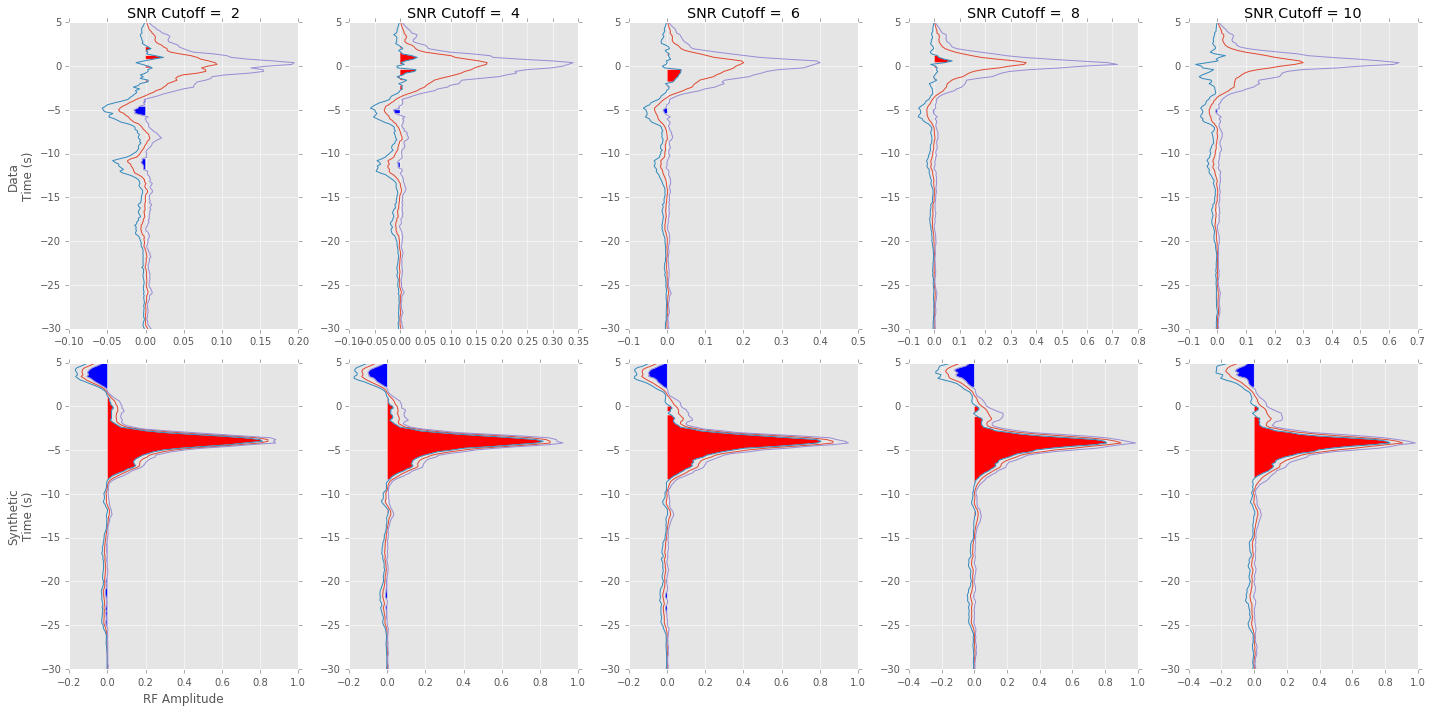

In [10]:
from numpy import nanmean, nanmedian, nanstd
from numpy.random import choice

#times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

#nrfs = len(cat2)
#nrfs = 329

minsnrs = arange(2, 12, 2)

#rbin_sn = rbin_s.copy() + randn(rbin_s.shape[0],rbin_s.shape[1],rbin_s.shape[2])*0.05

for iplt, minsnr in enumerate(minsnrs):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        snr_sample = arange(len(cat2))[mbin2[0,:]>minsnr]
        
        nrfs = len(snr_sample)
        
        rbin1=rbin0[0,snr_sample,:]
        
        nboot = 500

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        for iboot in range(nboot):
            random_sample = choice(range(nrfs), nrfs, replace=True)
            bbin[iboot,:] = nanmedian(rbin1[random_sample,:len(RF)],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(minsnrs),iplt+1)
        else:
            plt.subplot(2,len(minsnrs),iplt+1+len(minsnrs))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        if irow == 0:
            plt.title('SNR Cutoff = %2d' % (minsnr) )

plt.subplot(2,len(minsnrs),1)
plt.ylabel('Data\nTime (s)')
plt.subplot(2,len(minsnrs),1+len(minsnrs))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')

#plt.ylabel('Time (s)')
#plt.xlabel('RF Amplitude')
    
plt.tight_layout()
plt.savefig('RSSD_SNR.eps')

(array([ 742.,   87.,   41.,   17.,    6.,    8.,    4.,    3.,   19.,   20.]),
 array([  12.  ,   76.37,  140.74,  205.11,  269.48,  333.85,  398.22,
         462.59,  526.96,  591.33,  655.7 ]),
 <a list of 10 Patch objects>)

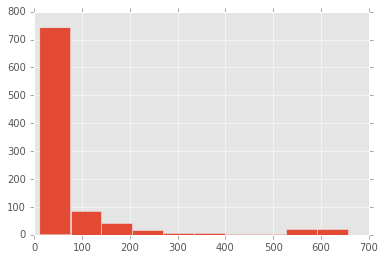

In [7]:
tmp=[]
for ievt, evt in enumerate(cat2):
    elat=evt.preferred_origin().latitude
    elon=evt.preferred_origin().longitude
    edep=evt.preferred_origin().depth/1000.0
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg = delm/1000./111.11
    tmp.append(edep)
    
plt.hist(tmp)

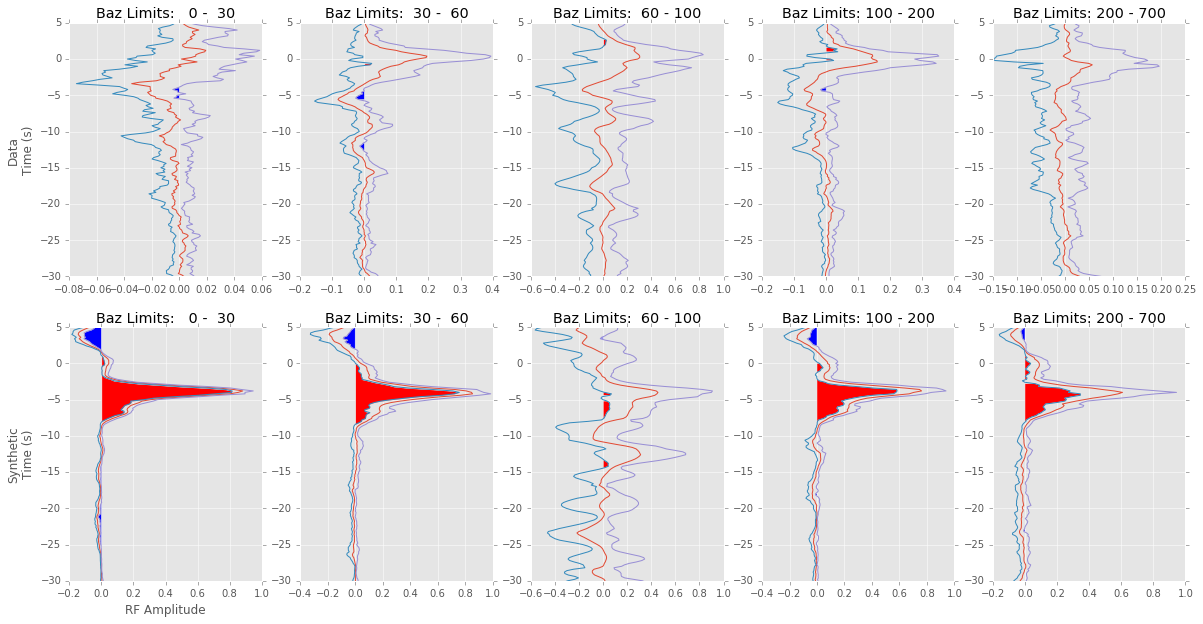

In [8]:
from numpy import nanmean, nanmedian, nanstd, array, shape
from numpy.random import choice

#times, RF = IDRF(P,D,dt)


depthranges = [(0,30),(30,60),(60,100),(100,200),(200,700)]

iplt = 4

for iplt, depthrange in enumerate(depthranges):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        dmin, dmax = depthrange[0], depthrange[1]

        slic = array(array(tmp) > dmin) & array(array(tmp) < dmax)

        #print(dmin, dmax, len(slic))

        nboot = 100

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        rbin2 = rbin0[0,slic,:len(RF)]
        nrf,_ = shape(rbin2)

        for iboot in range(nboot):

            random_sample = choice(range(nrf), nrf, replace=True)

            #print(nrf, len(random_sample))

            bbin[iboot,:] = nanmedian(rbin2[random_sample,:],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(depthranges),iplt+1)
        else:
            plt.subplot(2,len(depthranges),iplt+1+len(depthranges))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        #plt.xlim(-0.3,0.3)
        plt.title('Baz Limits: %3d - %3d' % (dmin, dmax))

plt.subplot(2,len(depthranges),1)
plt.ylabel('Data\nTime (s)')
        
plt.subplot(2,len(depthranges),1+len(depthranges))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')
    
#plt.tight_layout()
plt.savefig('RSSD_baz_limted.eps')